In [1]:
import torch.nn.utils.prune as prune

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms
from collections import OrderedDict
import time
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datetime import datetime

import torch.nn.utils.prune as prune

In [2]:
n_epochs = 10
mini_batch_size = 128
learning_rate = 0.01
momentum = 0.9
log_interval = 10

In [3]:
train_transforms = transforms.Compose([\
                transforms.Resize((32,32)),\
                transforms.ToTensor(),\
                transforms.Normalize(mean = (0.1307,), std = (0.3081,))\
])

test_transforms = transforms.Compose([\
                transforms.Resize((32,32)),\
                transforms.ToTensor(),\
                transforms.Normalize(mean = (0.1325,), std = (0.3105,))\
])

train_loader = DataLoader(torchvision.datasets.MNIST('data/',train=True, download=True, transform=train_transforms),batch_size=mini_batch_size)

test_loader = DataLoader(torchvision.datasets.MNIST('data/',train=False, download=True, transform=test_transforms), batch_size=mini_batch_size)

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.convnet = nn.Sequential(OrderedDict([
            ('c1' , nn.Conv2d(1,6, kernel_size=(5,5),) ),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2,2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5,5), )),
            ('relu2' , nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2,2), stride=2)) ,
            ('c5', nn.Conv2d(16, 120, kernel_size=(5,5)) ),
            ('relu3', nn.ReLU() ),]
        ))
        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84) ),
            ('relu6', nn.ReLU() ),
            ('f7', nn.Linear(84,10) ),
            ('sig7', nn.LogSoftmax(dim=-1) )
            ]
        ))


    def forward(self, x):
        out = self.convnet(x)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        return out


In [15]:
class ClassifierTraining:

    def __init__(self, classifer_model, train_loader: DataLoader, test_loader: DataLoader, prune_version=None):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = classifer_model.to(self.device)
        # self.model.to(self.device)
        self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate, momentum=momentum)
        self.train_losses = []
        self.train_counter = []
        self.test_counter = []
        self.test_losses = []
        self.train_loader = train_loader
        self.test_loader = test_loader
        if prune_version is None:
            self.version = 'base'
        else:
            self.version = prune_version

    def train(self, epoch, verbose=True):
        print(self.device)
        os.makedirs('results/',exist_ok=True)

        for batch_idx, (data,target) in enumerate(train_loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = F.nll_loss(output, target) # cross entropy loss
            loss.backward()
            self.optimizer.step()
            if batch_idx % log_interval == 0:
                if verbose:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(self.train_loader.dataset),\
                        100. * batch_idx / len(self.train_loader), loss.item()))
                self.train_losses.append(loss.item())
                self.train_counter.append(
                    (batch_idx * 128) + ((epoch - 1) * len(self.train_loader.dataset)))
                torch.save(self.model.state_dict(), f'results/model_{self.version}.pth')
                torch.save(self.optimizer.state_dict(), f'results/optimizer_{self.version}.pth')
    def test(self):
        self.model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                test_loss += F.nll_loss(output, target, size_average=True).item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()

        test_loss /= len(self.test_loader.dataset)
        self.test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(self.test_loader.dataset),
            100. * correct / len(self.test_loader.dataset)))

    def train_model(self,n_epoch):
        train_start_dt = datetime.now()
        self.test_counter = [i * len(self.train_loader.dataset) for i in range(n_epoch)]

        for ep in range(1, n_epoch+1):
            self.train(ep)
            self.test()
        train_end_dt = datetime.now()
        train_duration = (train_end_dt-train_start_dt)

        print(f"Total Training Time : {train_duration}")
        self.plot_train_test()

    def plot_train_test(self):
        fig = plt.figure()
        plt.plot(self.train_counter, self.train_losses, color='blue')
        plt.scatter(self.test_counter, self.test_losses, color='red')
        plt.legend(['Training Loss', 'Test Loss'], loc='upper right')
        plt.xlabel('No of Training Samples')
        plt.ylabel('Loss Function (NLL)')
        fig.savefig(f'results/training_curve_{self.version}.png')

In [19]:
# Show Model State Dictionary
def show_model_layers(model):
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())

def get_total_parameters_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def get_pruned_parameters_count(pruned_model):
    params = 0
    for param in pruned_model.parameters():
        if param is not None:
            params += torch.nonzero(param).size(0)
    return params

In [134]:
def run_pruning(sparsity_ratio, prune_method):
    version = f'{sparsity_ratio}-{prune_method.__name__}'


    prune_model = LeNet()
    
    prune_model.load_state_dict(torch.load('results/model_base.pth'))

    total_params_count = get_total_parameters_count(prune_model)
    
    parameters_to_prune = (
        (prune_model.convnet.c1,'weight'),
        (prune_model.convnet.c3,'weight'),
        (prune_model.convnet.c5,'weight'),
        (prune_model.fc.f6,'weight'),
        (prune_model.fc.f7,'weight'),
    )
    
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune_method,
        threshold=sparsity_ratio,
    )
    
    print(
        "Sparsity in c1.weight: {:.2f}%".format(
            100. * float(torch.sum(prune_model.convnet.c1.weight == 0))
            / float(prune_model.convnet.c1.weight.nelement())
        )
    )
    print(
        "Sparsity in c3.weight: {:.2f}%".format(
            100. * float(torch.sum(prune_model.convnet.c3.weight == 0))
            / float(prune_model.convnet.c3.weight.nelement())
        )
    )
    print(
        "Sparsity in c5.weight: {:.2f}%".format(
            100. * float(torch.sum(prune_model.convnet.c5.weight == 0))
            / float(prune_model.convnet.c5.weight.nelement())
        )
    )
    print(
        "Sparsity in f6.weight: {:.2f}%".format(
            100. * float(torch.sum(prune_model.fc.f6.weight == 0))
            / float(prune_model.fc.f6.weight.nelement())
        )
    )
    print(
        "Sparsity in f7.weight: {:.2f}%".format(
            100. * float(torch.sum(prune_model.fc.f7.weight == 0))
            / float(prune_model.fc.f7.weight.nelement())
        )
    )
    
    print(
        "Global sparsity: {:.2f}%".format(
            100. * float(
                torch.sum(prune_model.convnet.c1.weight == 0)
                + torch.sum(prune_model.convnet.c3.weight == 0)
                + torch.sum(prune_model.convnet.c5.weight == 0)
                + torch.sum(prune_model.fc.f6.weight == 0)
                + torch.sum(prune_model.fc.f7.weight == 0)
            )
            / float(
                prune_model.convnet.c1.weight.nelement()
                + prune_model.convnet.c3.weight.nelement()
                + prune_model.convnet.c5.weight.nelement()
                + prune_model.fc.f6.weight.nelement()
                + prune_model.fc.f7.weight.nelement()
            )
        )
    )
    
    prune.remove(prune_model.convnet.c1,'weight')
    prune.remove(prune_model.convnet.c3,'weight')
    prune.remove(prune_model.convnet.c5,'weight')
    prune.remove(prune_model.fc.f6,'weight')
    prune.remove(prune_model.fc.f7,'weight')
    
    pruned_classifer = ClassifierTraining(classifer_model=prune_model, train_loader=train_loader, test_loader=test_loader, prune_version=version)
    pruned_classifer.train_model(n_epoch=n_epochs)

    
    
    pruned_params_count = get_pruned_parameters_count(prune_model)
    print('Original Model paramete count:', total_params_count)
    print('Pruned Model parameter count:', pruned_params_count)
    compression_percent= (100 - (pruned_params_count / total_params_count) * 100)
    print(f'Compressed Percentage: {compression_percent}%')
    
    results = {\
        'train_losses':pruned_classifer.train_losses,\
        'test_losses':pruned_classifer.test_losses,\
        'train_counter':pruned_classifer.train_counter,\
        'test_counter':pruned_classifer.test_counter,\
        'pruned_params':pruned_params_count,\
        'compression_percent':compression_percent,}
    return results

Sparsity in c1.weight: 3.33%
Sparsity in c3.weight: 5.92%
Sparsity in c5.weight: 11.14%
Sparsity in f6.weight: 6.22%
Sparsity in f7.weight: 3.33%
Global sparsity: 10.00%
cuda
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.006772
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.029057
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.041821
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.007001
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.010217
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.012158
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.014793
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.000811
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.022588
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.002193
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.019859
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.004991
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.009874
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.016857
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.003081
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.001428
Train Epoch: 1 [20480/60000 (34%)]	Loss: 

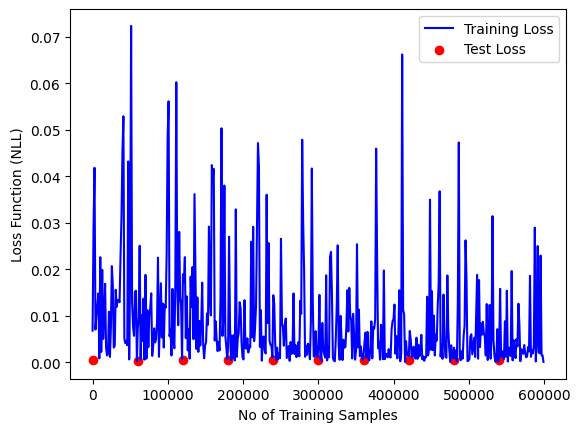

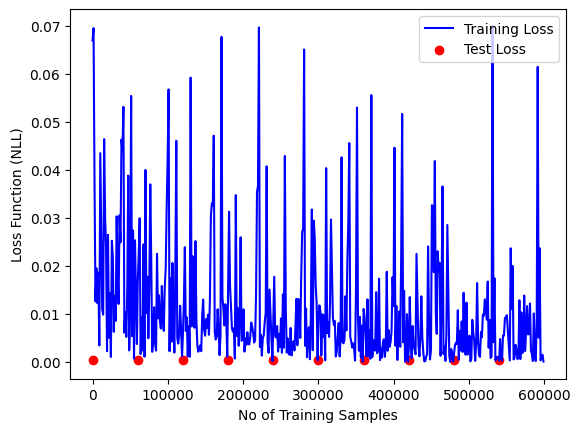

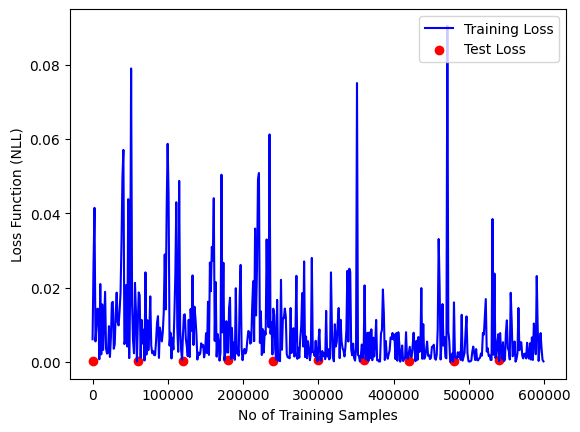

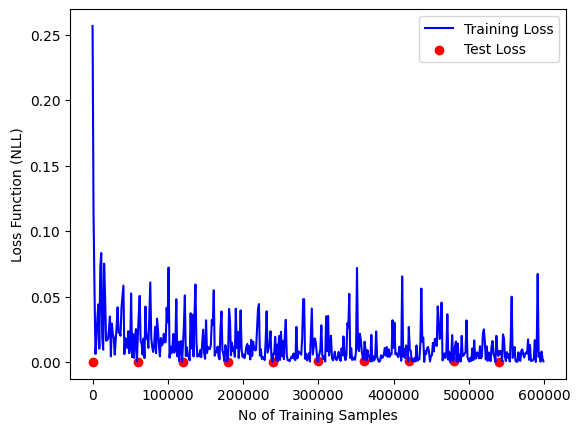

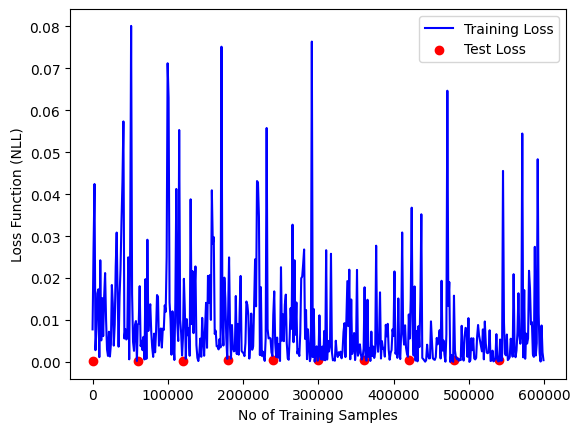

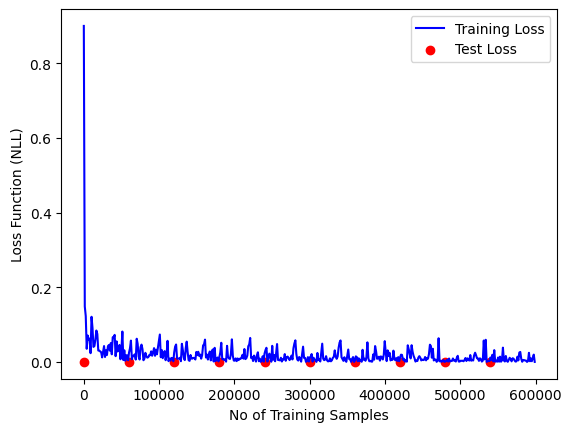

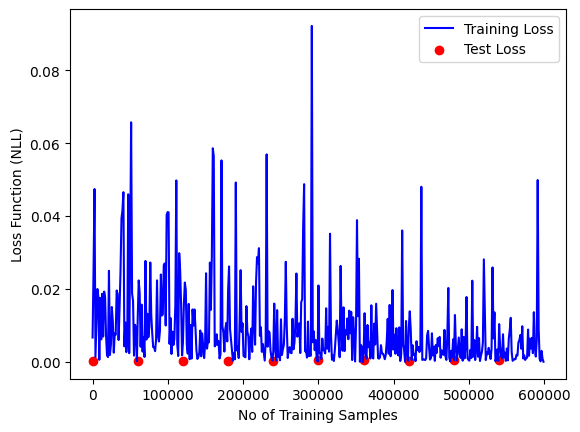

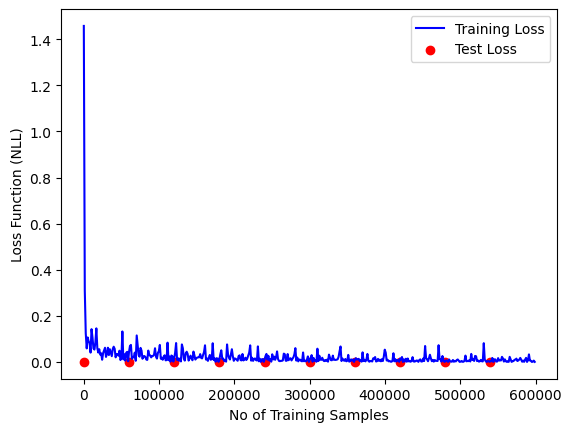

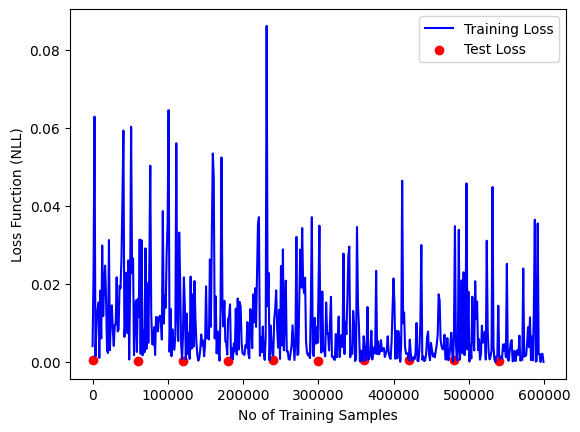

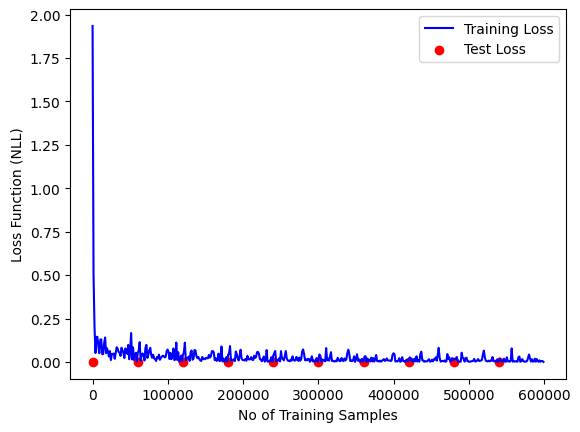

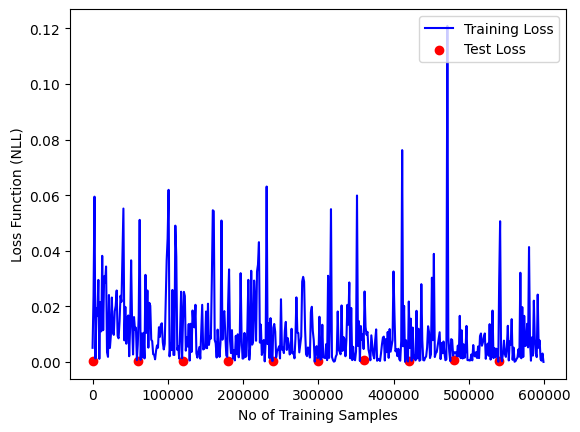

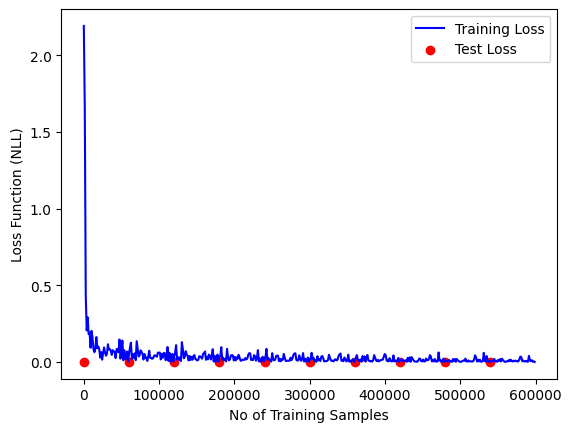

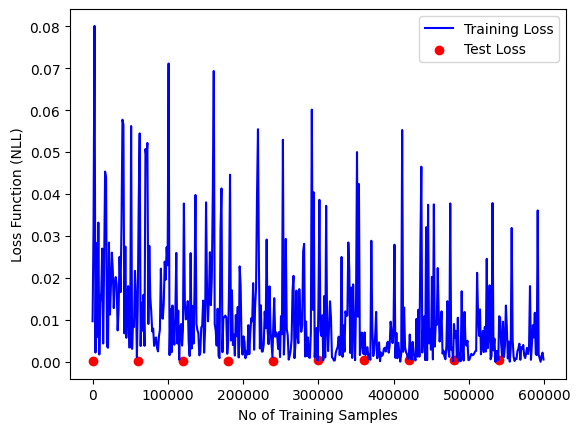

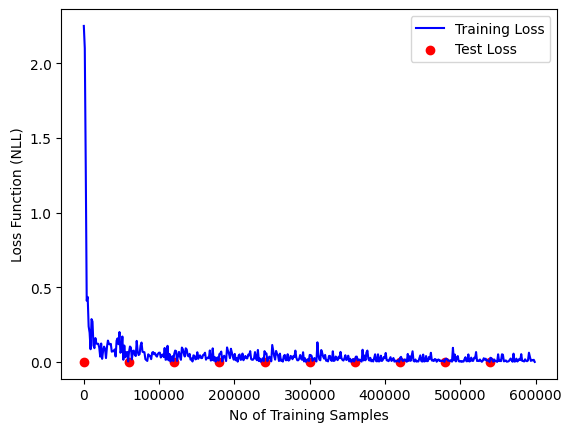

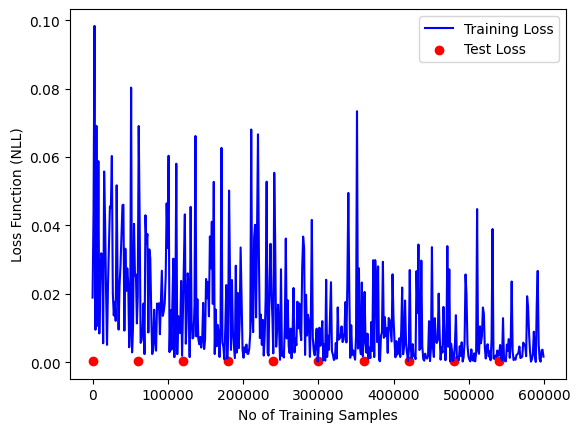

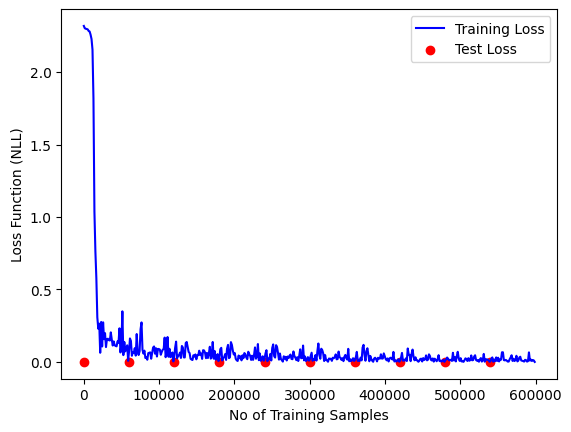

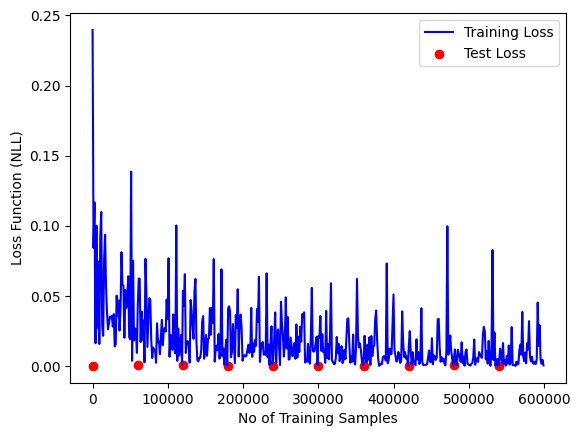

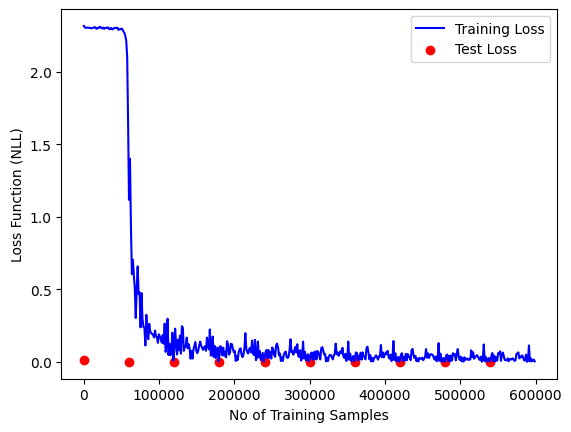

In [27]:
from itertools import product

## Run pruning for different sets of Sparsity Ratios and different Prune Methods
pruning_results = []
for sr,method in product([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] , [prune.L1Unstructured, prune.RandomUnstructured ] ):
    i = run_pruning(sparsity_ratio=sr,prune_method=method)
    pruning_results.append(i)


Sparsity in c1.weight: 24.67%
Sparsity in c3.weight: 77.21%
Sparsity in c5.weight: 98.46%
Sparsity in f6.weight: 87.52%
Sparsity in f7.weight: 50.48%
Global sparsity: 95.00%
cuda
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.952588
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.159299
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.159299
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.044376
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.138579
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.077814
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.117891
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.044642
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.199402
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.088895
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.043942
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.055424
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.122379
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.161494
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.051771
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.033343
Train Epoch: 1 [20480/60000 (34%)]	Lo

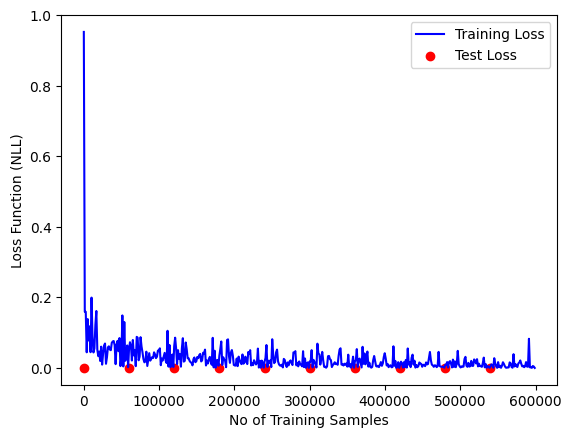

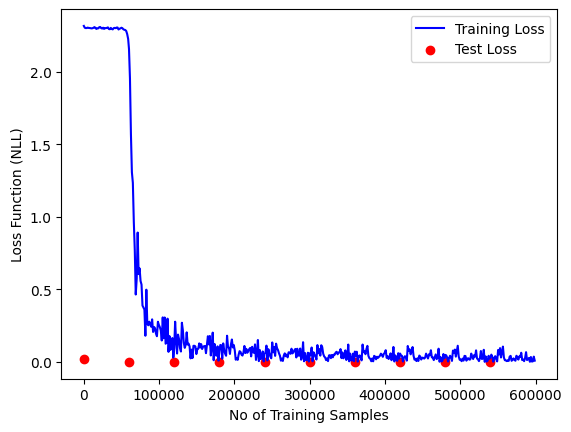

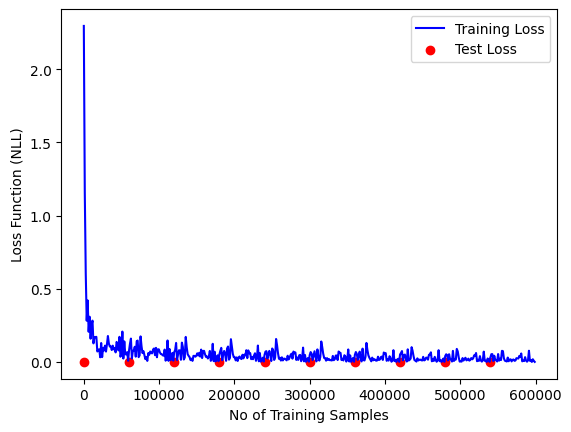

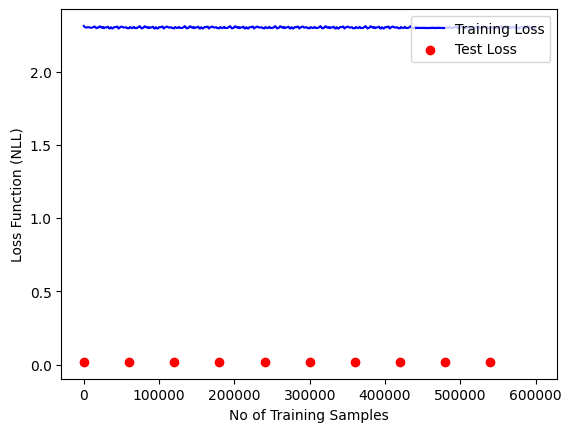

In [30]:
for sr,method in product([0.95,0.99] , [prune.L1Unstructured, prune.RandomUnstructured ] ):
    i = run_pruning(sparsity_ratio=sr,prune_method=method)
    pruning_results.append(i)

In [93]:
## Plot training and test loss for Pruned Models
import numpy as np
from matplotlib.collections import LineCollection

sr_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]
x = np.array(pruning_results[0]['train_counter'])
# ys = x[:len(pruning_results), np.newaxis] + x[np.newaxis, :]
# pruning_results[0]['train_counter']
# fig = plt.figure()
ys_l1 = np.array([])  #losses for l1 pruned
ys_random = np.array([]) #losses for random pruned
for i in range(len(pruning_results)):
    if i%2==0:
        ys_l1 = np.append(ys_l1,pruning_results[i]['train_losses'])
    else:
        ys_random = np.append(ys_random,pruning_results[i]['train_losses'])

print(ys_l1.shape)
ys_l1 =ys_l1.reshape(11,470)   
ys_random =ys_random.reshape(11,470)   

segs_l1 = np.zeros((11, 470, 2))
segs_l1[:, :, 1] = ys_l1
segs_l1[:, :, 0] = x

segs_random = np.zeros((11, 470, 2))
segs_random[:, :, 1] = ys_random
segs_random[:, :, 0] = x


    

(5170,)


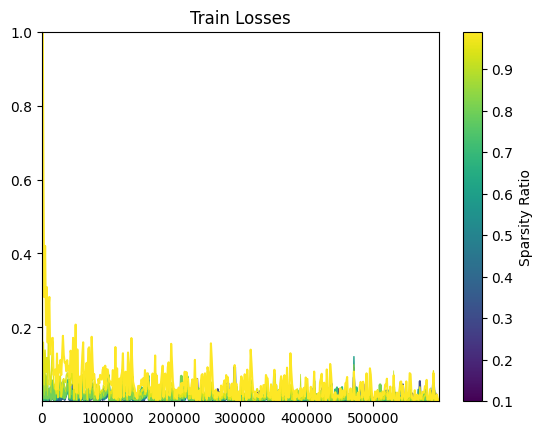

In [107]:
fig, ax = plt.subplots()
ax.set_xlim(x.min(), x.max())
ax.set_ylim(ys_l1.min(),1)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

line_segments = LineCollection(segs_l1, linewidths=(0.5, 1, 1.5, 2),
                               array=sr_list, linestyle='solid')
ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Sparsity Ratio')
ax.set_title('Train Losses')
plt.sci(line_segments)  # This allows interactive changing of the colormap.
plt.show()
fig.savefig(f'results/training_losses_l1_pruned.png')

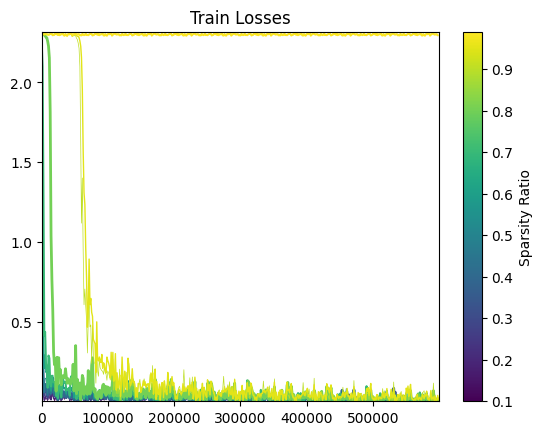

In [106]:
fig, ax = plt.subplots()
ax.set_xlim(x.min(), x.max())
ax.set_ylim(ys_random.min(), ys_random.max())

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

line_segments = LineCollection(segs_random, linewidths=(0.5, 1, 1.5, 2),
                               array=sr_list, linestyle='solid')
ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Sparsity Ratio')
ax.set_title('Train Losses')
plt.sci(line_segments)  # This allows interactive changing of the colormap.
plt.show()
fig.savefig(f'results/training_losses_random_pruned.png')

In [115]:
## Plot compression % and Sparsity ratio

x = np.array(sr_list)

# fig = plt.figure()
ys_comp_l1 = np.array([])  #losses for l1 pruned
ys_comp_random = np.array([]) #losses for random pruned
for i in range(len(pruning_results)):
    if i%2==0:
        ys_comp_l1 = np.append(ys_comp_l1,pruning_results[i]['compression_percent'])
    else:
        ys_comp_random = np.append(ys_comp_random,pruning_results[i]['compression_percent'])

print(ys_comp_l1.shape)
ys_comp_l1 =ys_comp_l1.reshape(11,1)   
ys_comp_random =ys_comp_random.reshape(11,)   

segs_comp_l1 = np.zeros((11, 11, 2))
segs_comp_l1[:, :, 1] = ys_comp_l1
segs_comp_l1[:, :, 0] = x

segs_comp_random = np.zeros((11, 11, 2))
segs_comp_random[:, :, 1] = ys_comp_random
segs_comp_random[:, :, 0] = x

ys_comp_l1
    

(11,)


array([[0.00000000e+00],
       [1.62058795e-03],
       [0.00000000e+00],
       [3.24117590e-03],
       [8.10293975e-03],
       [3.24117590e-03],
       [8.29741030e-01],
       [1.48607915e+00],
       [9.07691310e+00],
       [1.92866172e+01],
       [5.13045733e+01]])

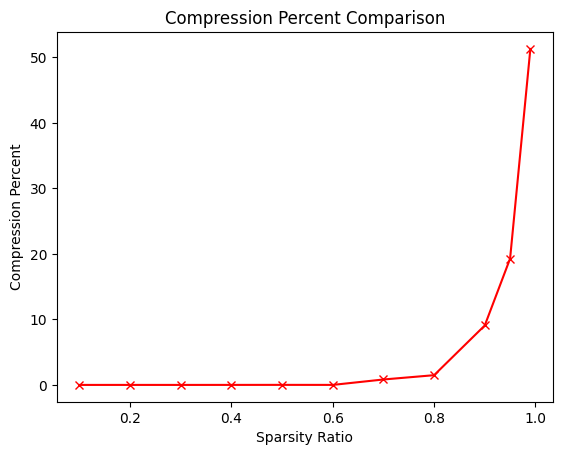

In [129]:
fig, ax = plt.subplots()
# ax.set_xlim(x.min(), x.max())
# ax.set_ylim(ys_comp_l1.min(),ys_comp_l1.max())

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.plot(sr_list, ys_comp_l1,'r-x',)

ax.set_title('Compression Percent Comparison')
plt.xlabel('Sparsity Ratio')
plt.ylabel('Compression Percent')
# plt.sci(line_segments)  # This allows interactive changing of the colormap.
plt.show()
fig.savefig(f'results/compression_l1_pruned.png')

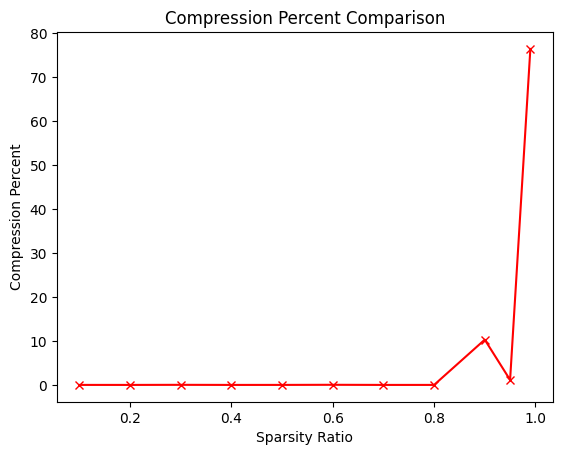

In [130]:
fig, ax = plt.subplots()
# ax.set_xlim(x.min(), x.max())
# ax.set_ylim(ys_comp_l1.min(),ys_comp_l1.max())

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.plot(sr_list, ys_comp_random,'r-x',)

ax.set_title('Compression Percent Comparison')
plt.xlabel('Sparsity Ratio')
plt.ylabel('Compression Percent')
# plt.sci(line_segments)  # This allows interactive changing of the colormap.
plt.show()
fig.savefig(f'results/compression_random_pruned.png')

In [144]:
## Custom Threshold Pruning method

#

class ThresholdPruning(prune.BasePruningMethod):
    PRUNING_TYPE = "unstructured"

    def __init__(self, threshold):
        self.threshold = threshold

    def compute_mask(self, tensor, default_mask):
        mid_value = torch.median(tensor)
        return torch.abs(mid_value) > self.threshold

In [143]:
def dry_run_pruning(sparsity_ratio, prune_method):
    version = f'{sparsity_ratio}-{prune_method.__name__}'


    prune_model = LeNet()
    
    prune_model.load_state_dict(torch.load('results/model_base.pth'))

    total_params_count = get_total_parameters_count(prune_model)
    
    parameters_to_prune = (
        (prune_model.convnet.c1,'weight'),
        (prune_model.convnet.c3,'weight'),
        (prune_model.convnet.c5,'weight'),
        (prune_model.fc.f6,'weight'),
        (prune_model.fc.f7,'weight'),
    )
    
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune_method,
        threshold=sparsity_ratio,
    )
    
    print(
        "Sparsity in c1.weight: {:.2f}%".format(
            100. * float(torch.sum(prune_model.convnet.c1.weight == 0))
            / float(prune_model.convnet.c1.weight.nelement())
        )
    )
    print(
        "Sparsity in c3.weight: {:.2f}%".format(
            100. * float(torch.sum(prune_model.convnet.c3.weight == 0))
            / float(prune_model.convnet.c3.weight.nelement())
        )
    )
    print(
        "Sparsity in c5.weight: {:.2f}%".format(
            100. * float(torch.sum(prune_model.convnet.c5.weight == 0))
            / float(prune_model.convnet.c5.weight.nelement())
        )
    )
    print(
        "Sparsity in f6.weight: {:.2f}%".format(
            100. * float(torch.sum(prune_model.fc.f6.weight == 0))
            / float(prune_model.fc.f6.weight.nelement())
        )
    )
    print(
        "Sparsity in f7.weight: {:.2f}%".format(
            100. * float(torch.sum(prune_model.fc.f7.weight == 0))
            / float(prune_model.fc.f7.weight.nelement())
        )
    )
    
    print(
        "Global sparsity: {:.2f}%".format(
            100. * float(
                torch.sum(prune_model.convnet.c1.weight == 0)
                + torch.sum(prune_model.convnet.c3.weight == 0)
                + torch.sum(prune_model.convnet.c5.weight == 0)
                + torch.sum(prune_model.fc.f6.weight == 0)
                + torch.sum(prune_model.fc.f7.weight == 0)
            )
            / float(
                prune_model.convnet.c1.weight.nelement()
                + prune_model.convnet.c3.weight.nelement()
                + prune_model.convnet.c5.weight.nelement()
                + prune_model.fc.f6.weight.nelement()
                + prune_model.fc.f7.weight.nelement()
            )
        )
    )

In [148]:
# thresold_pruning_results = []
# for sr,method in product([0.4] , [ThresholdPruning] ):
#     dry_run_pruning(sparsity_ratio=sr,prune_method=method)

Sparsity in c1.weight: 100.00%
Sparsity in c3.weight: 100.00%
Sparsity in c5.weight: 100.00%
Sparsity in f6.weight: 100.00%
Sparsity in f7.weight: 100.00%
Global sparsity: 100.00%
